In [1]:
import os
import pathlib
import sys
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import pickle

# Co Contraction Experiments

## Import experimental data

In [2]:
folder_path = "/home/jan/dev/reflex-controller/data/co_contraction_experiment"
step_number = 0.1 # here, we can choose all step sizes form the experiments, like 0.01, 0.1, 0.2, 0.5

file_pattern = re.compile(r"^(.*)_([0-9]*\.[0-9]+)\.pkl$")

loaded_files = {}

for filename in os.listdir(folder_path):
    match = file_pattern.match(filename)
    if match:
        file_step_number = float(match.group(2))
        if step_number == file_step_number:
            filepath = os.path.join(folder_path, filename)
            with open(filepath, "rb") as f:
                loaded_files[match.group(1)] = pickle.load(f)

In [3]:
np.array(loaded_files["FL_calf_joint"]["torque"]).shape

(39600, 1, 24)

In [4]:
joint_mapping = {
    'FL_hip_joint': 0, 
    'FR_hip_joint': 1, 
    'RL_hip_joint': 2, 
    'RR_hip_joint': 3, 
    'FL_thigh_joint': 4, 
    'FR_thigh_joint': 5, 
    'RL_thigh_joint': 6, 
    'RR_thigh_joint': 7, 
    'FL_calf_joint': 8, 
    'FR_calf_joint': 9, 
    'RL_calf_joint': 10, 
    'RR_calf_joint': 11
}

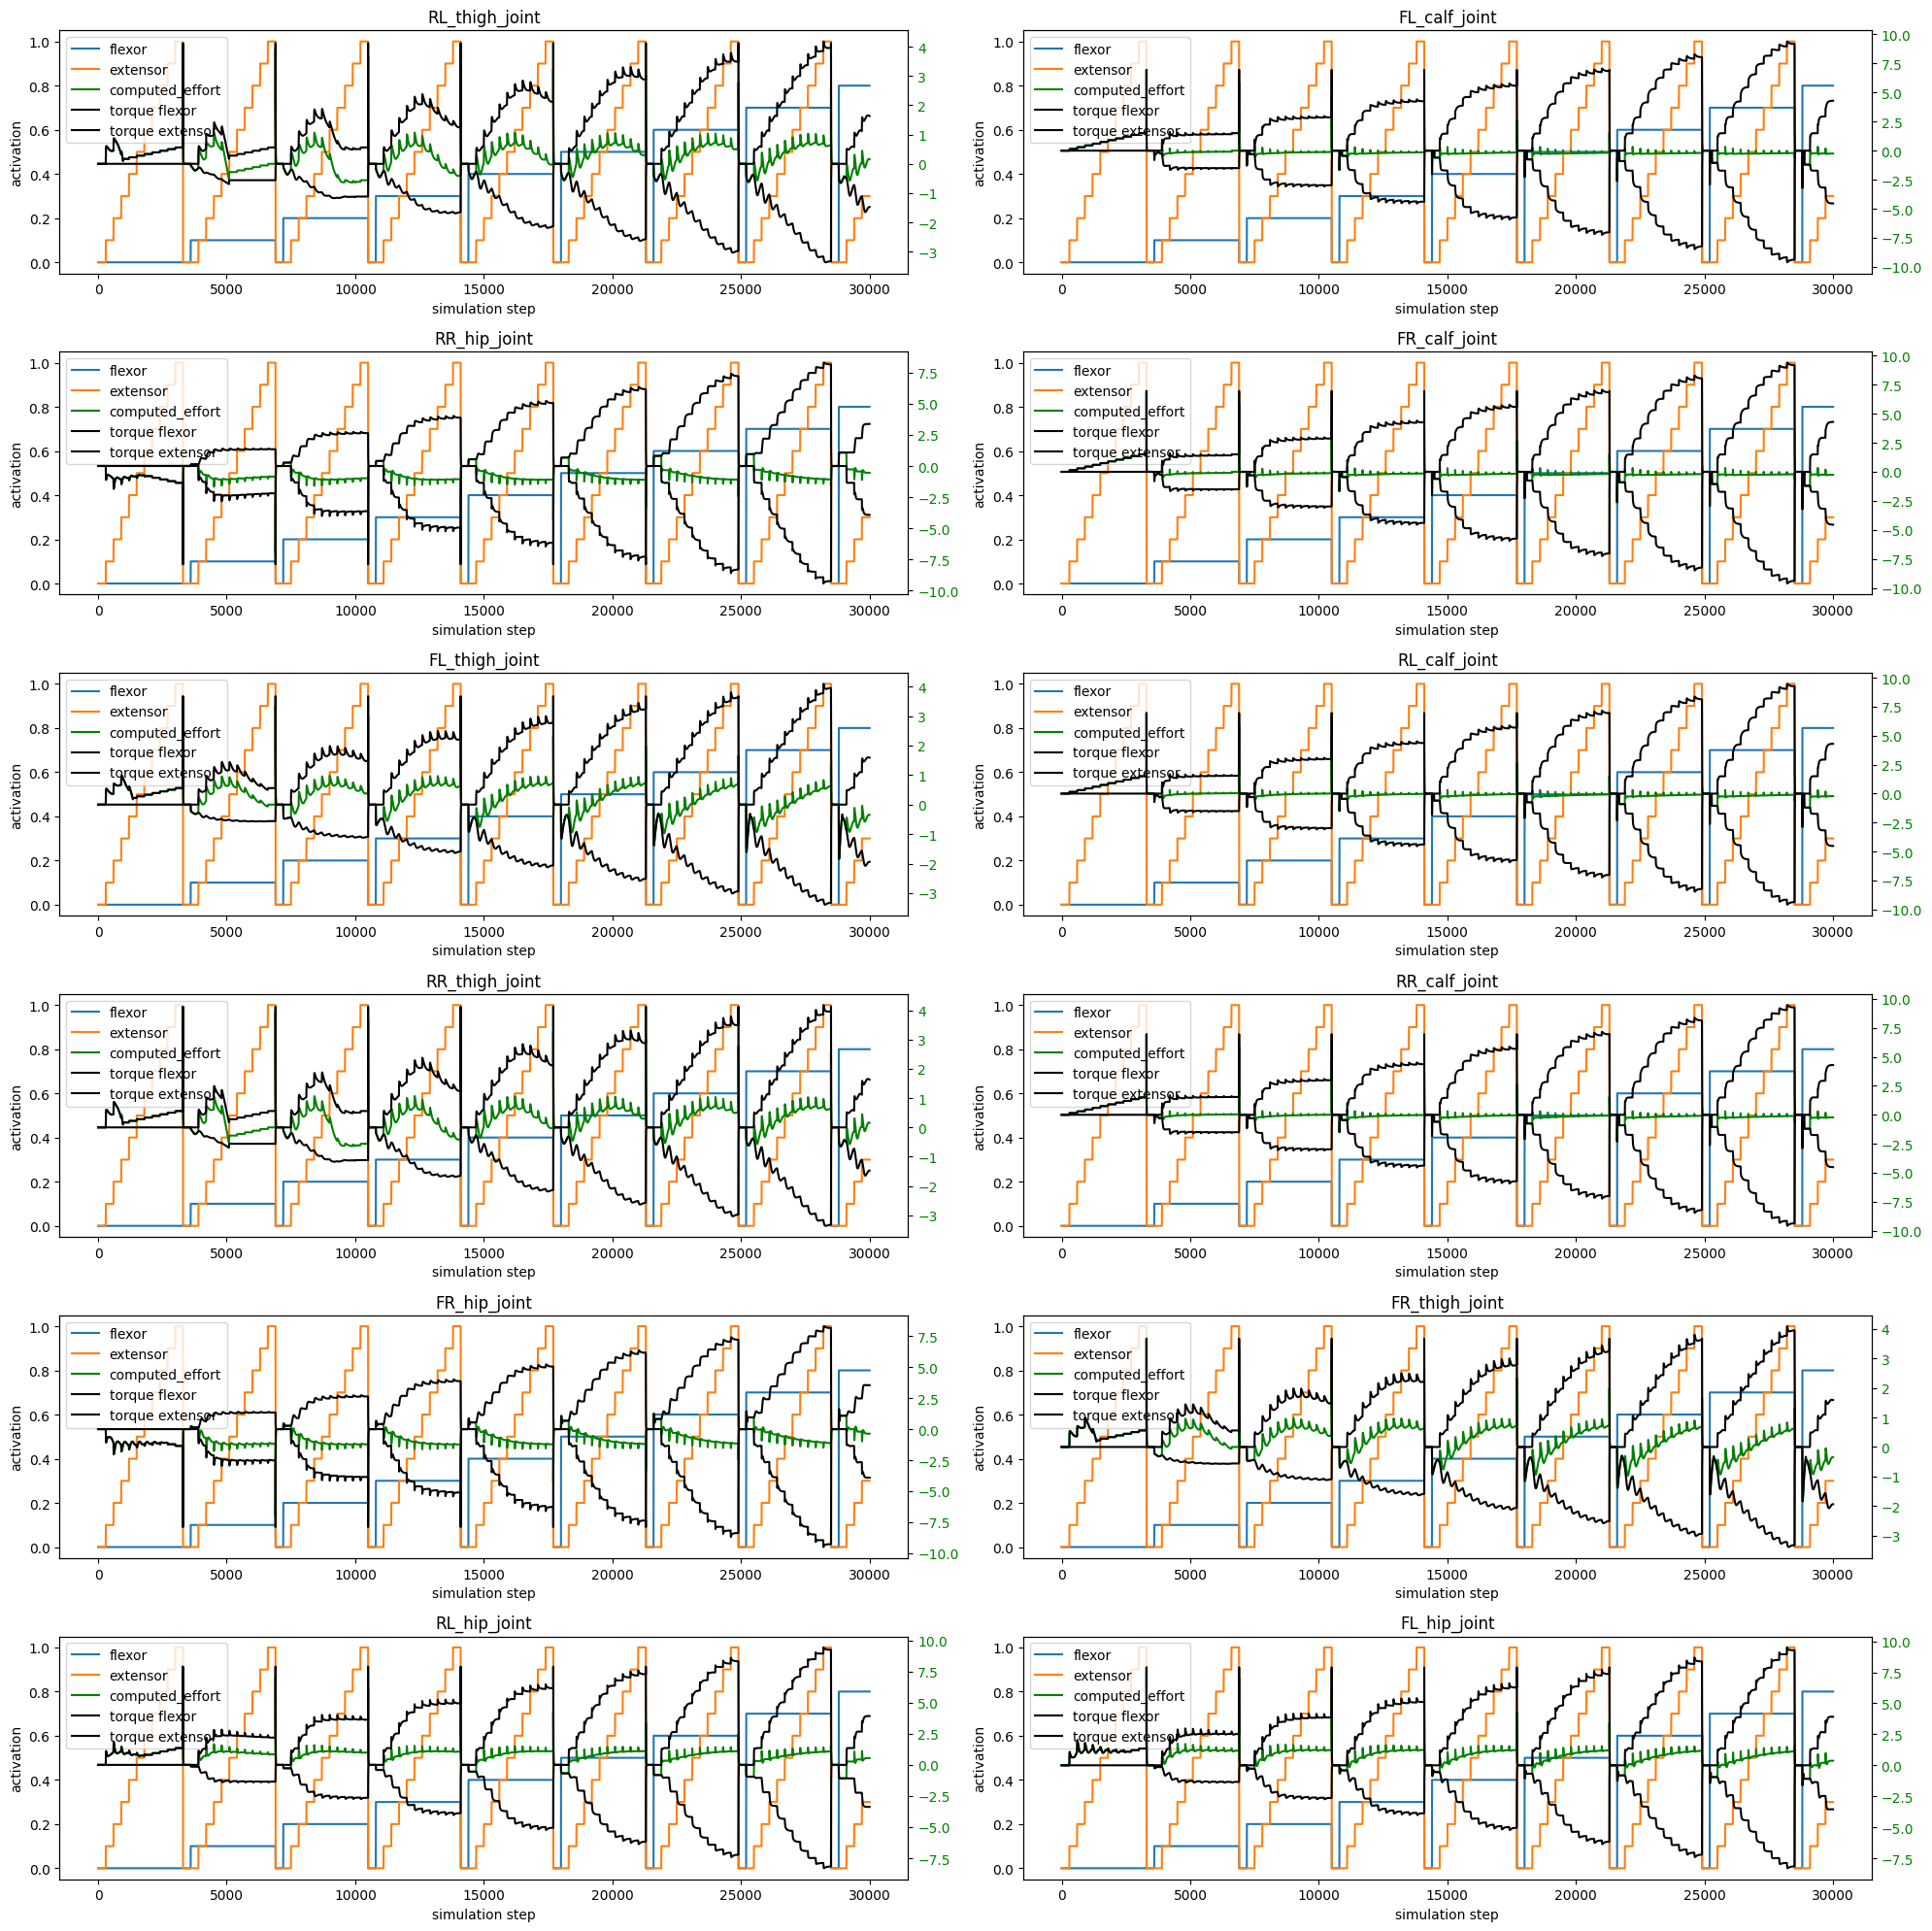

In [5]:
fig, ax = plt.subplots(int(len(loaded_files.keys()) / 2), 2, figsize=(20, 20), tight_layout=True)

for i, joint_name in enumerate(loaded_files.keys()):
    ax[i // 2][i % 2].plot(np.array(loaded_files[joint_name]["clipped_activations"])[:100 * 300, 0, joint_mapping[joint_name]], label="flexor")
    ax[i // 2][i % 2].plot(np.array(loaded_files[joint_name]["clipped_activations"])[:100 * 300, 0, joint_mapping[joint_name] + 12], label="extensor")

    ax[i // 2][i % 2].set_ylabel("activation")
    ax[i // 2][i % 2].set_xlabel("simulation step")
    
    position_ax = ax[i // 2][i % 2].twinx()
    position_ax.plot(np.array(loaded_files[joint_name]["computed_effort"])[:100 * 300, 0, joint_mapping[joint_name]], color="green", label="computed_effort")
    position_ax.plot(np.array(loaded_files[joint_name]["torque"])[:100 * 300, 0, joint_mapping[joint_name]], color="black", label="torque flexor")
    position_ax.plot(np.array(loaded_files[joint_name]["torque"])[:100 * 300, 0, joint_mapping[joint_name] + 12], color="black", label="torque extensor")
    #position_ax.plot(np.array(loaded_files[joint_name]["joint_position"])[:100 * 300, 0, joint_mapping[joint_name]], color="green", label="joint position")
    position_ax.tick_params(axis="y", labelcolor="g")

    lines, labels = ax[i // 2][i % 2].get_legend_handles_labels()
    lines2, labels2 = position_ax.get_legend_handles_labels()

    ax[i // 2][i % 2].legend(lines + lines2, labels + labels2, loc="upper left")
    
    ax[i // 2][i % 2].set_title(joint_name)

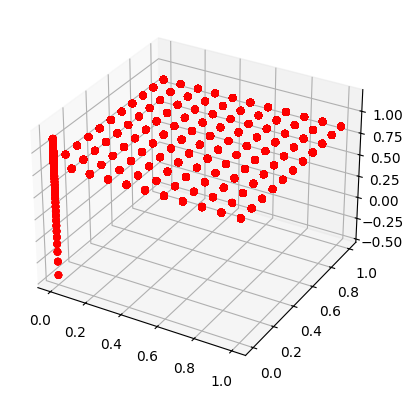

In [6]:
x = np.array(loaded_files["FL_hip_joint"]["raw_activations"])[:, 0, 0]
y = np.array(loaded_files["FL_hip_joint"]["raw_activations"])[:, 0, 12]
z = np.array(loaded_files["FR_hip_joint"]["computed_effort"])[:, 0, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, c="r", marker="o")

plt.show()

# Fvmax and Vmax optimization
## Import data

In [7]:
folder_path = "/home/jan/dev/reflex-controller/data/vmax_fvmax_tuning"

def parse_filename(filename):
    """
    Parses filenames like <joint_name>_fvmax_<float>_vmax_<float>.pkl
    Returns (joint_name, fvmax, vmax) or None if not matching.
    """
    pattern = r"^(.*)/(.*?)_fvmax_([-+]?\d*\.\d+|\d+)_vmax_([-+]?\d*\.\d+|\d+)\.pkl$"
    match = re.match(pattern, filename)
    if match:
        joint_name = match.group(2)
        fvmax = float(match.group(3))
        vmax = float(match.group(4))
        return joint_name, fvmax, vmax
    return None

def load_files_to_dict(folder_path):
    result = {}
    for fname in os.listdir(folder_path):
        if fname.endswith(".pkl"):
            full_path = os.path.join(folder_path, fname)
            parsed = parse_filename(full_path)

            if parsed:
                joint_name, fvmax, vmax = parsed

                with open(full_path, 'rb') as f:
                    data = pickle.load(f)
                if joint_name not in result:
                    result[joint_name] = {}

                result[joint_name][(fvmax, vmax)] = data

    return result

dict = load_files_to_dict(folder_path)

In [8]:
joint_mapping = {
    'FL_hip_joint': 0, 
    'FR_hip_joint': 1, 
    'RL_hip_joint': 2, 
    'RR_hip_joint': 3, 
    'FL_thigh_joint': 4, 
    'FR_thigh_joint': 5, 
    'RL_thigh_joint': 6, 
    'RR_thigh_joint': 7, 
    'FL_calf_joint': 8, 
    'FR_calf_joint': 9, 
    'RL_calf_joint': 10, 
    'RR_calf_joint': 11
}

goal_positions = {
    'FL_hip_joint': 0.60, 
    'RL_hip_joint': 0.62, 
    'FL_thigh_joint': 2.36, 
    'RL_thigh_joint': 3.72, 
    'FL_calf_joint': -1.16, 
    'RL_calf_joint': -1.17, 
}

def composite_performance_index(x, t, target, band=0.02, weights=(0.1,10,10,0.5), negative=False):
    a, b, c, d = weights
    # Settling time
    try:
        t_settle = true_settling_time(x, t, target, band)
    except IndexError:
        t_settle = t[-1]
    # Overshoot
    if not negative:
        overshoot = np.abs(np.max(x) - target)
    else:
        overshoot = np.abs(target - np.min(x))
    # Wigglyness (total absolute second derivative)
    d2x = np.diff(x, n=2) / np.diff(t[:-1])**2
    wigglyness = np.sum(np.abs(d2x)) * (t[1]-t[0])
    # Steady-state error
    sse = np.abs(x[-1] - target)
    # Composite index
    CPI = a*t_settle + b*overshoot + c*wigglyness + d*sse
    return CPI

def true_settling_time(x, t, target, band=0.02):
    # Compute error at each time
    err = np.abs(x - target)
    band_val = band * np.abs(target)
    # Start from the last point and move backward
    for i in range(len(x)):
        # Check if from t[i:] onward, all values are within band
        if np.all(err[i:] < band_val):
            return t[i]
    return t[-1]  # Never settled

def square_error(x, target):
    return np.sqrt(np.sum((x - target) ** 2))


# get the keys with the best performance measures among thigh joints.
def get_top_n_keys(dict, n, joints=None, metric=None):
    performance = {}

    if joints is None:
        joints = dict.keys()

    # create performance measures
    for joint_name in joints:
        performance[joint_name] = []
        for key in dict[joint_name].keys():
            if metric == 'MSE':
                performance_index = square_error(np.array(dict[joint_name][key]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]], goal_positions[joint_name])
            else:
                performance_index = composite_performance_index(np.array(dict[joint_name][key]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]], np.arange(500), goal_positions[joint_name])
            performance[joint_name].append((key, performance_index))

        performance[joint_name] = sorted(performance[joint_name], key=lambda x: x[1])

        
    # search for intersecting keys, until the top n keys are chosen
    result = []
    count = 1
    while len(result) < n: 
        top_key_sets = []
        for joint_name, top_metrics in performance.items():
            keys, metric = zip(*(top_metrics[:count]))

            top_key_sets.append(set(keys))

        result = list(set.intersection(*top_key_sets))

        count += 1

    return result, performance   

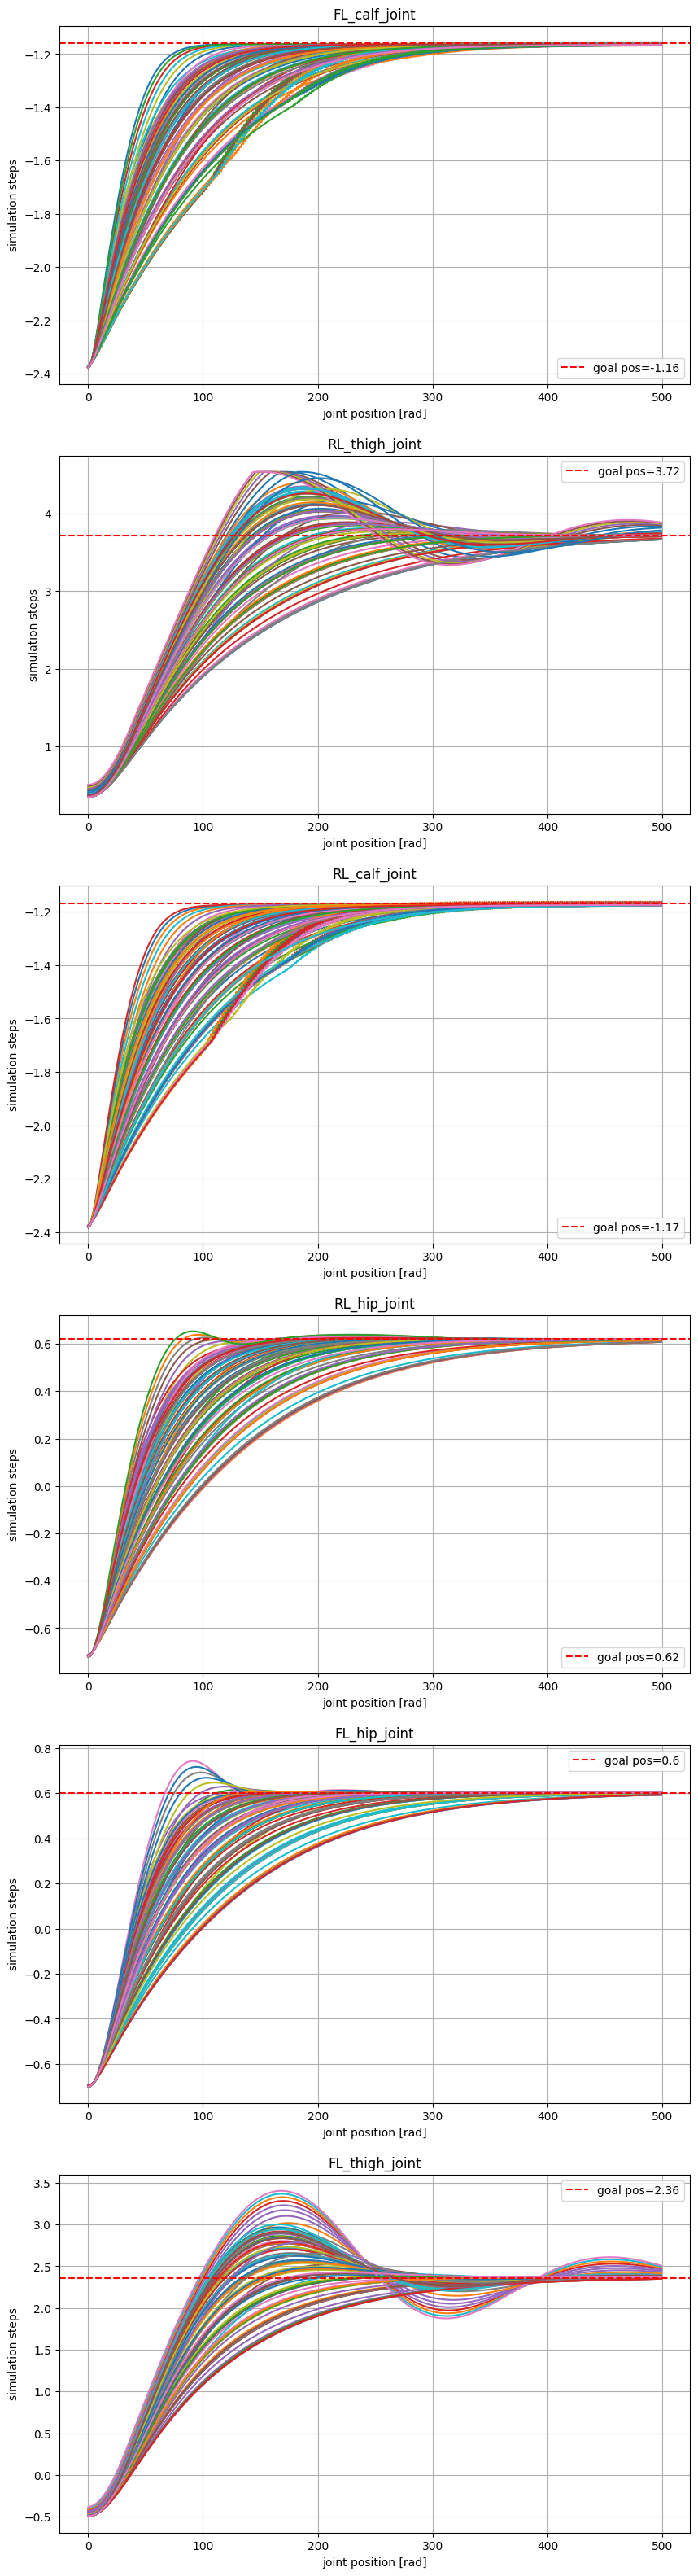

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 1, figsize=(10, 40))

for i, joint_name in enumerate(dict.keys()):
    for key in dict[joint_name]:
        line, = ax[i].plot(np.array(dict[joint_name][key]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]])
    
    ax[i].axhline(y=goal_positions[joint_name], color="r", linestyle='--', label=f'goal pos={goal_positions[joint_name]}')
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_title(joint_name)
    ax[i].set_xlabel("joint position [rad]")
    ax[i].set_ylabel("simulation steps")

plt.show()

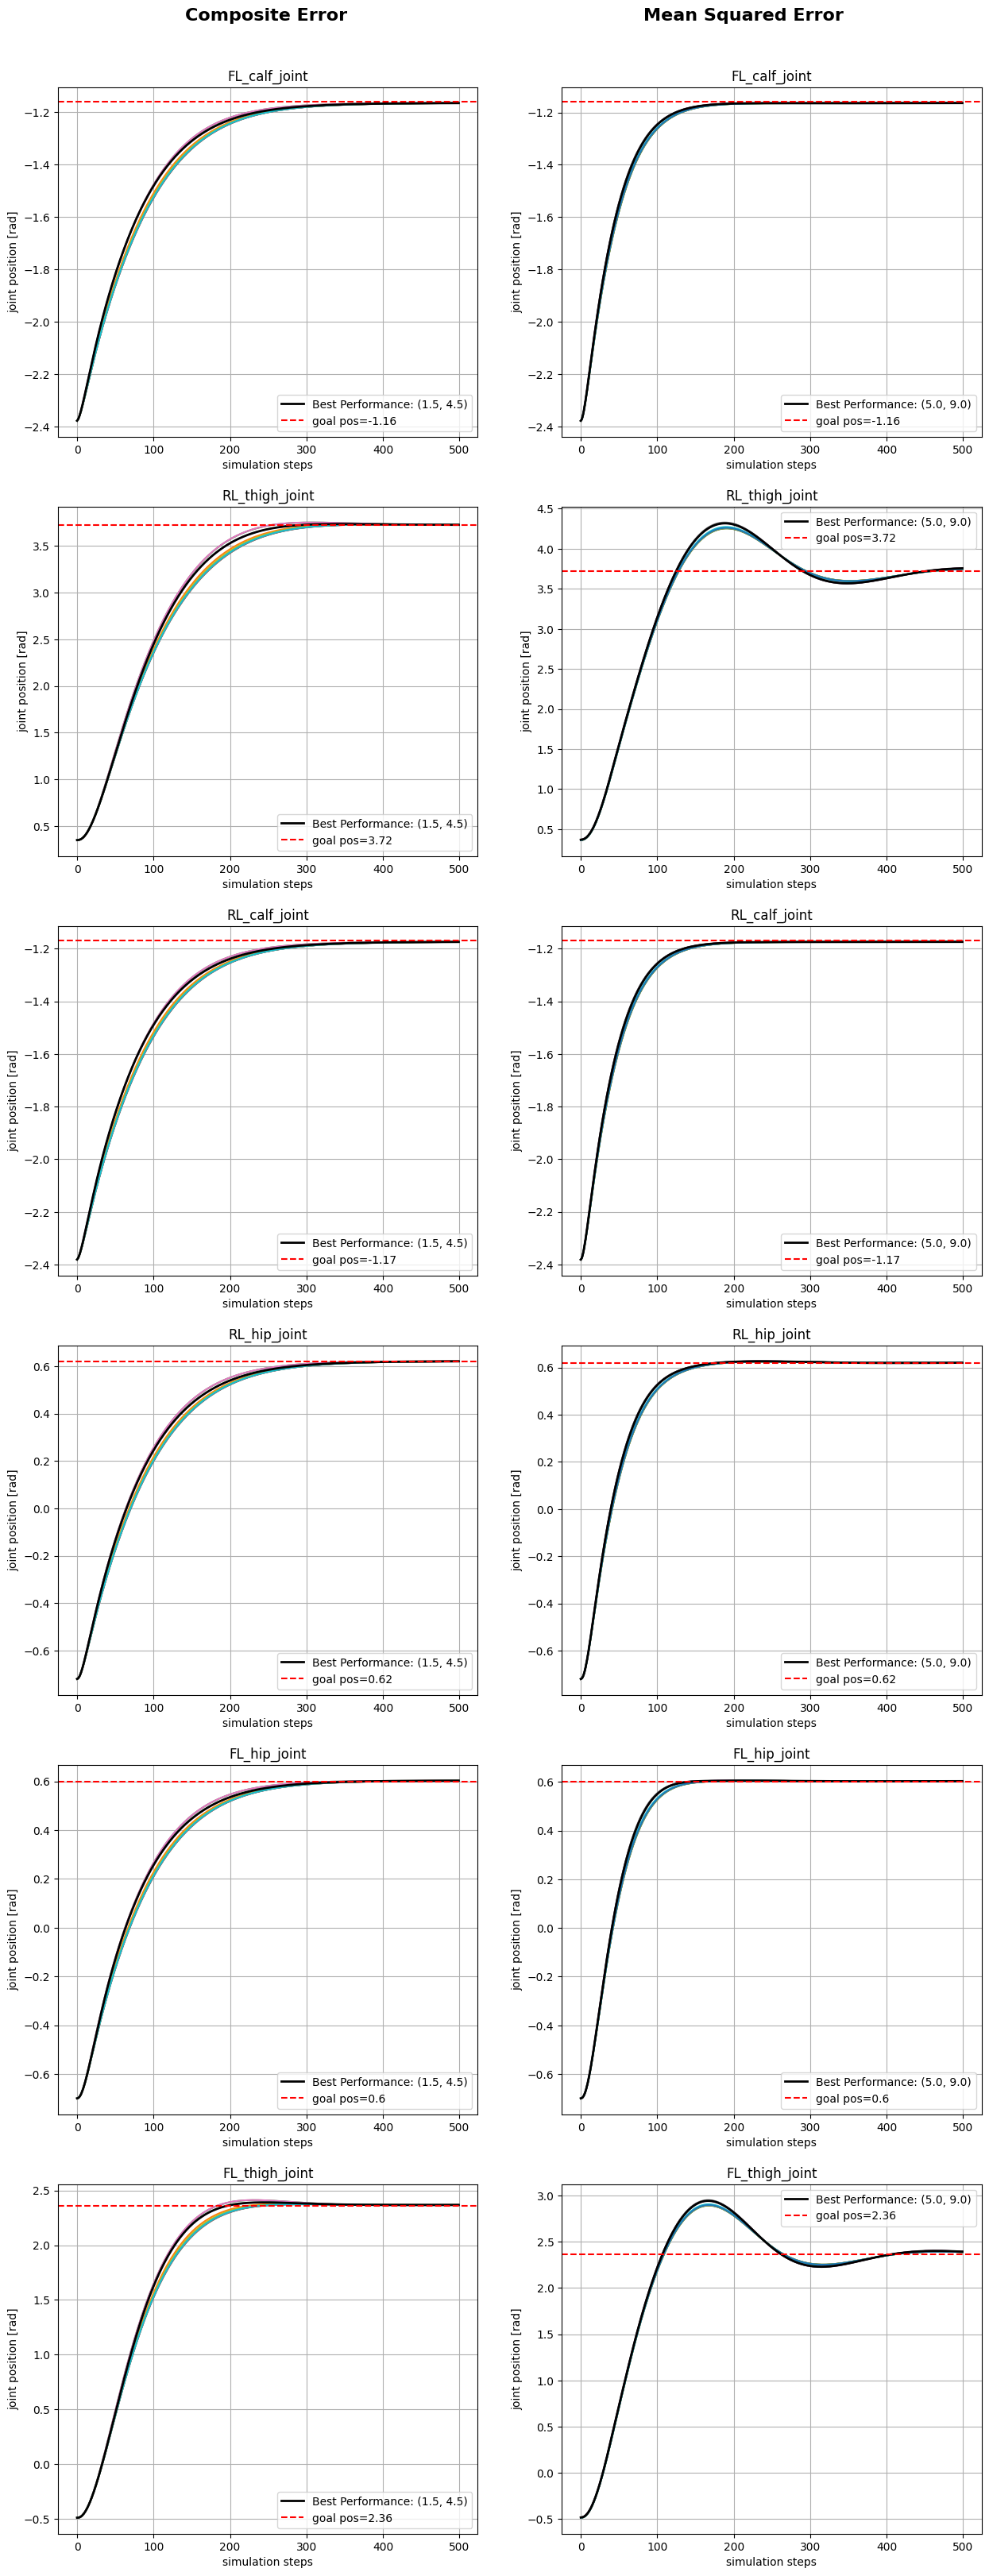

In [10]:
fig, ax = plt.subplots(6, 2, figsize=(15, 40))
joints = ["FL_thigh_joint", "RL_thigh_joint"]
top_key_MSE, _ = get_top_n_keys(dict, 1, joints=joints, metric="MSE")
top_keys_MSE, _ = get_top_n_keys(dict, 10, joints=joints, metric="MSE")
top_key, _ = get_top_n_keys(dict, 1, joints=joints)
top_keys, _ = get_top_n_keys(dict, 10, joints=joints)

fig.text(0.30, 0.90, 'Composite Error', ha='center', va='bottom', fontsize=16, fontweight='bold')
fig.text(0.7, 0.90, 'Mean Squared Error', ha='center', va='bottom', fontsize=16, fontweight='bold')

for i, joint_name in enumerate(dict.keys()):
    for key in top_keys:
        ax[i][0].plot(np.array(dict[joint_name][key]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]])

    for key in top_keys_MSE:
        ax[i][1].plot(np.array(dict[joint_name][key]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]])

    ax[i][0].plot(np.array(dict[joint_name][top_key[0]]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]], linewidth=2, color="black", label=f"Best Performance: {top_key[0]}")
    ax[i][1].plot(np.array(dict[joint_name][top_key_MSE[0]]["joint_position"])[1500:2000, 0, joint_mapping[joint_name]], linewidth=2, color="black", label=f"Best Performance: {top_key_MSE[0]}")

    ax[i][0].set_title(joint_name)
    ax[i][1].set_title(joint_name)
    ax[i][0].grid(True)
    ax[i][1].grid(True)
    ax[i][0].axhline(y=goal_positions[joint_name], color="r", linestyle='--', label=f'goal pos={goal_positions[joint_name]}')
    ax[i][1].axhline(y=goal_positions[joint_name], color="r", linestyle='--', label=f'goal pos={goal_positions[joint_name]}')
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][0].set_ylabel("joint position [rad]")
    ax[i][0].set_xlabel("simulation steps")
    ax[i][1].set_ylabel("joint position [rad]")
    ax[i][1].set_xlabel("simulation steps")

plt.show()

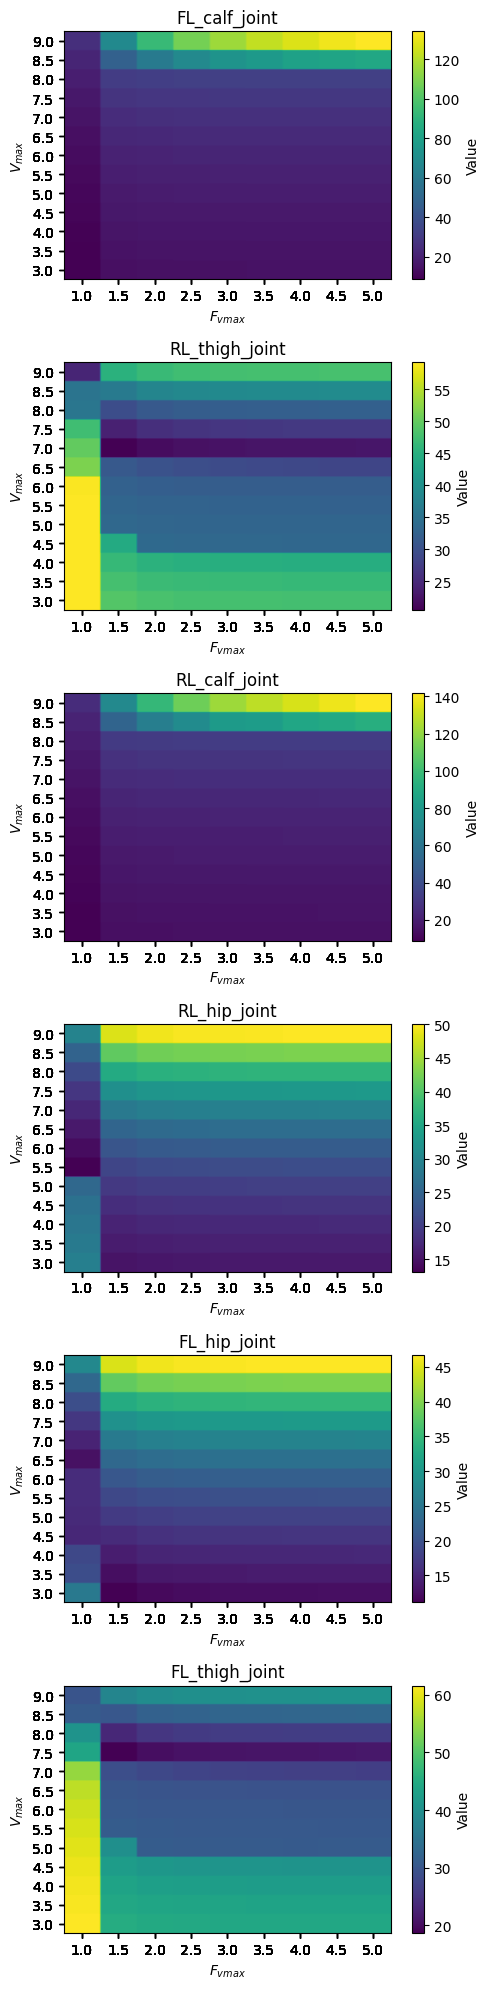

In [11]:
_, performance = get_top_n_keys(dict, 0)

fig, ax = plt.subplots(len(performance.keys()), 1, figsize=(5, 20), tight_layout=True)

for axi, joint_name in enumerate(performance.keys()):
    x_vals = sorted([x for (x, _), _ in performance[joint_name]])
    y_vals = sorted([y for (_, y), _ in performance[joint_name]], reverse=True)

    value_map = {(x, y): v for (x, y), v in performance[joint_name]}

    z = np.empty((len(x_vals), len(y_vals)))
    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            z[i, j] = value_map[(x, y)]

    img = ax[axi].imshow(z, aspect='auto', cmap='viridis', extent=[min(x_vals) - 0.25, max(x_vals) + 0.25, min(y_vals) - 0.25, max(y_vals) + 0.25], origin='lower')
    fig.colorbar(img, ax=ax[axi], label='Value')
    ax[axi].set_xticks(x_vals)
    ax[axi].set_yticks(y_vals)
    ax[axi].set_ylabel(f'$V_{{max}}$')
    ax[axi].set_xlabel(f'$F_{{vmax}}$')
    ax[axi].set_title(joint_name)


